# ModelChain example

This example shows you the basic usage of the windpowerlib by using the ``ModelChain`` class.
There are mainly three steps. First you have to import your weather data, then you need to specify your wind turbine, and in the last step call the windpowerlib functions to calculate the feed-in time series.

Before you start you have to import the packages needed for these steps.

### Import necessary packages and modules

In [1]:
__copyright__ = "Copyright oemof developer group"
__license__ = "GPLv3"

import os
import pandas as pd

from windpowerlib.modelchain import ModelChain
from windpowerlib.wind_turbine import WindTurbine
from windpowerlib import wind_turbine as wt

You can use the logging package to get logging messages from the windpowerlib. Change the logging level if you want more or less messages.

In [2]:
import logging
logging.getLogger().setLevel(logging.DEBUG)

### Import weather data

In order to use the windpowerlib you need to at least provide wind speed data for the time frame you want to analyze.
The function below imports example weather data from the weather.csv file provided along with the windpowerlib. The data include wind speed at two different heights in m/s, air temperature in two different heights in K, surface roughness length in m and air pressure in Pa.

To find out which weather data in which units need to be provided to use the ModelChain or other functions of the windpowerlib see the individual function documentation.

In [3]:
def get_weather_data(filename='weather.csv', **kwargs):
    r"""
    Imports weather data from a file.

    The data include wind speed at two different heights in m/s, air
    temperature in two different heights in K, surface roughness length in m
    and air pressure in Pa. The file is located in the example folder of the
    windpowerlib. The height in m for which the data applies is specified in
    the second row.

    Parameters
    ----------
    filename : string
        Filename of the weather data file. Default: 'weather.csv'.

    Other Parameters
    ----------------
    datapath : string, optional
        Path where the weather data file is stored.
        Default: 'windpowerlib/example'.

    Returns
    -------
    weather_df : pandas.DataFrame
        DataFrame with time series for wind speed `wind_speed` in m/s,
        temperature `temperature` in K, roughness length `roughness_length`
        in m, and pressure `pressure` in Pa.
        The columns of the DataFrame are a MultiIndex where the first level
        contains the variable name (e.g. wind_speed) and the second level
        contains the height at which it applies (e.g. 10, if it was
        measured at a height of 10 m).

    """

    if 'datapath' not in kwargs:
        kwargs['datapath'] = os.path.join(os.path.split(
            os.path.dirname(__file__))[0], 'example')
    file = os.path.join(kwargs['datapath'], filename)
    # read csv file 
    weather_df = pd.read_csv(file, index_col=0, header=[0, 1])
    # change type of index to datetime and set time zone
    weather_df.index = pd.to_datetime(weather_df.index).tz_localize(
        'UTC').tz_convert('Europe/Berlin')
    # change type of height from str to int by resetting columns
    weather_df.columns = [weather_df.axes[1].levels[0][
                              weather_df.axes[1].labels[0]],
                          weather_df.axes[1].levels[1][
                              weather_df.axes[1].labels[1]].astype(int)]
    return weather_df


# Read weather data from csv
weather = get_weather_data(filename='weather.csv', datapath='')
print(weather[['wind_speed', 'temperature', 'pressure']][0:3])

variable_name             wind_speed          temperature         pressure
height                            10       80          2       10       0 
2010-01-01 00:00:00+01:00    5.32697  7.80697      267.60  267.57  98405.7
2010-01-01 01:00:00+01:00    5.46199  7.86199      267.60  267.55  98382.7
2010-01-01 02:00:00+01:00    5.67899  8.59899      267.61  267.54  98362.9


### Initialize wind turbine

To initialize a specific turbine you need a dictionary that contains the basic parameters. A turbine is defined by its nominal power, hub height, rotor diameter, and power or power coefficient curve.

There are two ways to initialize a WindTurbine object in the windpowerlib. You can either specify your own turbine, as done below for 'myTurbine', or fetch power and/or power coefficient curve data from data files provided by the windpowerlib, as done for the 'enerconE126'.

You can execute the following to get a list of all wind turbines for which power or power coefficient curves are provided.

In [4]:
# get power curves
# get names of wind turbines for which power curves are provided (default)
# set print_out=True to see the list of all available wind turbines
wt.get_turbine_types(print_out=False)

# get power coefficient curves
# write names of wind turbines for which power coefficient curves are provided
# to 'turbines' DataFrame
turbines = wt.get_turbine_types(filename='power_coefficient_curves.csv', print_out=False)
# find all Enercons in 'turbines' DataFrame
print(turbines[turbines["turbine_id"].str.contains("ENERCON")])

            turbine_id    p_nom
52   ENERCON E 70 2300  2300000
64  ENERCON E 101 3000  3000000
65  ENERCON E 126 7500  7500000
66  ENERCON E 115 2500  2500000
67    ENERCON E 48 800   800000
68   ENERCON E 82 2000  2000000
69    ENERCON E 53 800   800000
70   ENERCON E 58 1000  1000000
71   ENERCON E 70 2000  2000000
72   ENERCON E 82 2300  2300000
73   ENERCON E 82 3000  3000000
74   ENERCON E 92 2300  2300000
75  ENERCON E 112 4500  4500000


In [5]:
# specification of own wind turbine (Note: power coefficient values and
# nominal power have to be in Watt)
myTurbine = {
    'name': 'myTurbine',
    'nominal_power': 3e6,  # in W
    'hub_height': 105,  # in m
    'rotor_diameter': 90,  # in m
    'power_curve': pd.DataFrame(
            data={'power': [p * 1000 for p in [
                      0.0, 26.0, 180.0, 1500.0, 3000.0, 3000.0]],  # in W
                  'wind_speed': [0.0, 3.0, 5.0, 10.0, 15.0, 25.0]})  # in m/s
    }  
# initialisze WindTurbine object
my_turbine = WindTurbine(**myTurbine)

In [6]:
# specification of wind turbine where power curve is provided
# if you want to use the power coefficient curve change the value of
# 'fetch_curve' to 'power_coefficient_curve'
enerconE126 = {
    'name': 'ENERCON E 126 7500',  # turbine name as in register
    'hub_height': 135,  # in m
    'rotor_diameter': 127,  # in m
    'fetch_curve': 'power_curve'  # fetch power curve
}
# initialize WindTurbine object
e126 = WindTurbine(**enerconE126)

### Use the ModelChain to calculate turbine power output

The ModelChain is a class that provides all necessary steps to calculate the power output of a wind turbine. If you use the 'run_model' method first the wind speed and density (if necessary) at hub height are calculated and then used to calculate the power output. You can either use the default methods for the calculation steps, as done for 'my_turbine', or choose different methods, as done for the 'e126'.

In [7]:
# power output calculation for my_turbine
# initialize ModelChain with default parameters and use run_model
# method to calculate power output
mc_my_turbine = ModelChain(my_turbine).run_model(weather)
# write power output time series to WindTurbine object
my_turbine.power_output = mc_my_turbine.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating power output using power curve.


In [8]:
# power output calculation for e126
# own specifications for ModelChain setup
modelchain_data = {
    'wind_speed_model': 'logarithmic',      # 'logarithmic' (default),
                                            # 'hellman' or
                                            # 'interpolation_extrapolation'
    'density_model': 'ideal_gas',           # 'barometric' (default), 'ideal_gas'
                                            #  or 'interpolation_extrapolation'
    'temperature_model': 'linear_gradient', # 'linear_gradient' (def.) or
                                            # 'interpolation_extrapolation'
    'power_output_model': 'power_curve',    # 'power_curve' (default) or
                                            # 'power_coefficient_curve'
    'density_correction': True,             # False (default) or True
    'obstacle_height': 0,                   # default: 0
    'hellman_exp': None}                    # None (default) or None

# initialize ModelChain with own specifications and use run_model method to
# calculate power output
mc_e126 = ModelChain(e126, **modelchain_data).run_model(
    weather)
# write power output time series to WindTurbine object
e126.power_output = mc_e126.power_output

DEBUG:root:Calculating wind speed using logarithmic wind profile.
DEBUG:root:Calculating temperature using temperature gradient.
DEBUG:root:Calculating density using ideal gas equation.
DEBUG:root:Calculating power output using power curve.


### Plot results

If you have matplotlib installed you can visualize the calculated power output and used power (coefficient) curves.

In [9]:
# try to import matplotlib
try:
    from matplotlib import pyplot as plt
    # matplotlib inline needed in notebook to plot inline
    %matplotlib inline 
except ImportError:
    plt = None

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/sabine/virtualenvs/windpowerlib/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


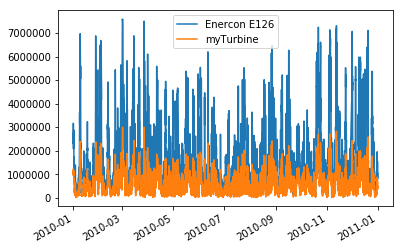

In [10]:
# plot turbine power output
if plt:
    e126.power_output.plot(legend=True, label='Enercon E126')
    my_turbine.power_output.plot(legend=True, label='myTurbine')
    plt.show()

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/sabine/virtualenvs/windpowerlib/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


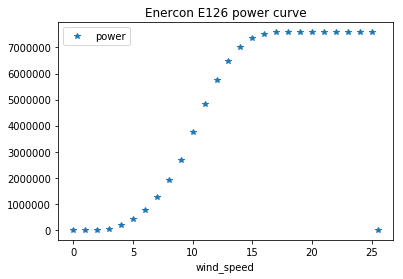

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


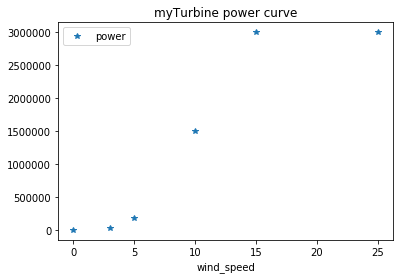

In [11]:
# plot power (coefficient) curves
if plt:
    if e126.power_coefficient_curve is not None:
        e126.power_coefficient_curve.plot(
            x='wind_speed', y='power coefficient', style='*',
            title='Enercon E126 power coefficient curve')
        plt.show()
    if e126.power_curve is not None:
        e126.power_curve.plot(x='wind_speed', y='power', style='*',
                              title='Enercon E126 power curve')
        plt.show()
    if my_turbine.power_coefficient_curve is not None:
        my_turbine.power_coefficient_curve.plot(
            x='wind_speed', y='power coefficient', style='*',
            title='myTurbine power coefficient curve')
        plt.show()
    if my_turbine.power_curve is not None:
        my_turbine.power_curve.plot(x='wind_speed', y='power', style='*',
                                    title='myTurbine power curve')
        plt.show()